In [1]:
#pip install graphviz
#!pip install graphviz
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    # this to be used before defining the grad in the notebook
    #dot.node(name = uid, label = "{ %s | data %.4f}" % (n.label, n.data), shape='record')
    # this to be used after defining the grad
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [42]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [116]:
# Now we need to inform of the operation of each step by adding _op 

class Value:
    def __init__(self,data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    def __repr__(self):
        return f"Value(data={self.data})"
    def __add__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data + other.data, (self,other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    def __mul__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data * other.data, (self,other), '*')
        def _backward():
            self.grad += other.data * out.grad 
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    def __rmul__(self, other): #Function that will be called is python can't do 5 * Value(2)
        return self * other
    def __truediv__(self,other): # self/other
        return self * other**-1
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only support int/float powers"
        out = Value(self.data**other, (self,), f'**{other}')
        def _backward():
            self.grad += (other)*self.data**(other-1) * out.grad
        out._backward = _backward
        return out
    def __neg__(self):
        return self * -1
    def __sub__(self, other):
        return self + (-other)
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')
        def _backward():
           self.grad += (1 - t**2) * out.grad  
        out._backward = _backward
        return out
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')
        def _backward():
            self.grad += math.exp(x) * out.grad
        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
        
    

In [29]:
#inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#weight w1,w2
w1 = Value(-3.0,label='w1')
w2 = Value(1.0,label='w2')

#bias b
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2 ; x1w1x2w2.label = 'x1w1+x2w2'
n = x1w1x2w2 + b ; n.label='n'
out = n.tanh(); out.label = 'o'


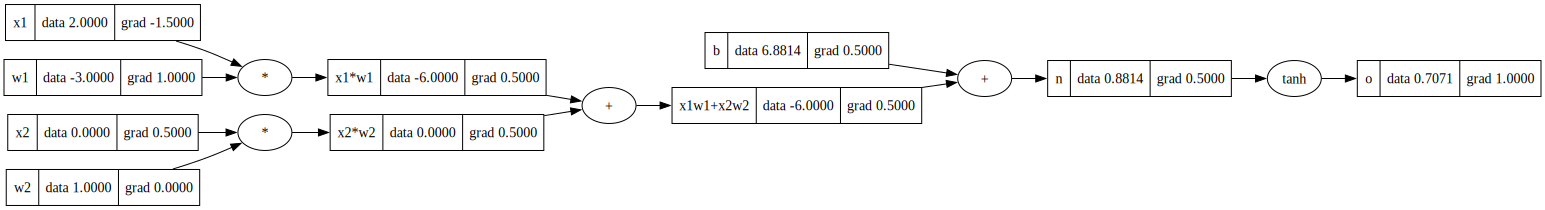

In [5]:
out.backward()
draw_dot(out)

In [28]:
a = Value(2.0)
b = Value(4.0)
a - b

Value(data=-2.0)

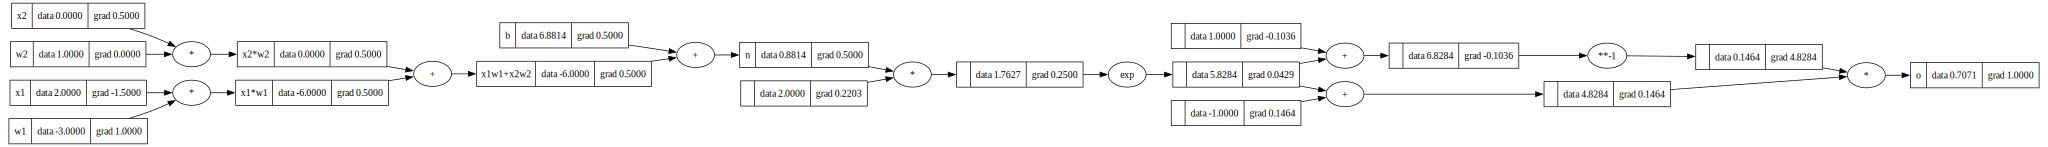

In [30]:
#inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#weight w1,w2
w1 = Value(-3.0,label='w1')
w2 = Value(1.0,label='w2')

#bias b
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2 ; x1w1x2w2.label = 'x1w1+x2w2'
n = x1w1x2w2 + b ; n.label='n'

e = (2*n).exp()
o = (e - 1)/ (e + 1)
o.label = 'o'
o.backward()
draw_dot(o)

In [33]:
## Same autograd using Pytorch
import torch
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data)
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

tensor([0.7071], dtype=torch.float64)
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [151]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
    def __call__(self,x):
        # w * x + b
        act = sum((wi*xi for wi,xi in zip(self.w,x)), Value(0.0)) + self.b
        out = act.tanh()
        return out
    def parameters(self):
        return self.w + [self.b]
class Layer:
    def __init__(self, nin,nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    def __call__(self,x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    def parameters(self):
        #return [p for neuron in self.neurons for p in neuron.parameters()]
        params = []
        for neuron in self.neurons:
            ps = neuron.parameters()
            params.extend(ps)
        return params
class MLP:
    def __init__(self,nin, nouts):
        sz = [nin] + nouts # [n_x] + [n_layer1, n_layer2...] 
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

    

In [152]:
random.seed(5)
x = [2.0, 3.0, -1.0]
n = MLP(3,[4,4,1])
n(x)

Value(data=0.9229263852574531)

In [153]:
n.parameters()

[Value(data=0.24580338977940386),
 Value(data=0.4835739785214588),
 Value(data=0.5903871311313933),
 Value(data=0.8849005675541006),
 Value(data=0.4797971494798614),
 Value(data=0.844649993330834),
 Value(data=-0.9419895434327705),
 Value(data=-0.0687546912437893),
 Value(data=0.8867134339966274),
 Value(data=0.2979491062738484),
 Value(data=0.8018009835012454),
 Value(data=-0.7735880706937113),
 Value(data=-0.06186190443567252),
 Value(data=-0.5068543347603394),
 Value(data=0.08752171847186085),
 Value(data=0.14788237585620156),
 Value(data=-0.9737716208221956),
 Value(data=-0.5665403990723037),
 Value(data=-0.44103526797777937),
 Value(data=0.8326907436171038),
 Value(data=0.5314509032582835),
 Value(data=-0.6807915752839235),
 Value(data=0.594293982862409),
 Value(data=-0.7224651632021937),
 Value(data=0.2349050409322333),
 Value(data=-0.7466015348994606),
 Value(data=-0.9964502755949307),
 Value(data=0.7428094894485642),
 Value(data=-0.5810872350097642),
 Value(data=-0.569037661550

In [158]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets  
ypred = [n(x) for x in xs]
ypred

[Value(data=0.8052269087267314),
 Value(data=-0.9062204996278859),
 Value(data=-0.8064995524705505),
 Value(data=0.8962464635113371)]

In [155]:
loss = [(yout - ygt)**2 for ygt, yout in zip(ys, ypred)]
loss

[Value(data=0.005940342089482547),
 Value(data=2.8220711868298936),
 Value(data=3.3555498642080055),
 Value(data=0.021115852858313047)]

In [156]:
loss = sum(((yout - ygt)**2 for ygt, yout in zip(ys, ypred)), Value(0.0))
loss


Value(data=6.204677245985694)

In [159]:

for k in range(50):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum(((yout - ygt)**2 for ygt, yout in zip(ys, ypred)), Value(0.0))
  
  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()
  
  # update
  for p in n.parameters():
    p.data += -0.01 * p.grad
  
  print(k, loss.data)

0 0.09493837130218992
1 0.09254758968624396
2 0.090260557941477
3 0.08807099673085979
4 0.085973106977819
5 0.08396152593558456
6 0.08203128790063577
7 0.08017778901567851
8 0.07839675568122763
9 0.07668421615775164
10 0.07503647499417346
11 0.07345008996474633
12 0.07192185123608842
13 0.07044876252047466
14 0.06902802400114175
15 0.06765701684106092
16 0.06633328910894838
17 0.06505454297569457
18 0.06381862305131926
19 0.06262350574733647
20 0.06146728956235109
21 0.06034818620004025
22 0.059264512438634565
23 0.05821468267976229
24 0.05719720211224197
25 0.05621066043320939
26 0.0552537260749876
27 0.054325140891429056
28 0.053423715262184125
29 0.0525483235775382
30 0.05169790007018811
31 0.050871434963643034
32 0.05006797090989548
33 0.04928659969164209
34 0.04852645916669874
35 0.04778673043436123
36 0.04706663520535566
37 0.04636543335872007
38 0.04568242067048228
39 0.04501692670036685
40 0.04436831282400383
41 0.04373597039921488
42 0.043119319055963425
43 0.0425178051004554
